In [1]:
from __future__ import absolute_import, division

import os
import urllib, cStringIO

import pymongo as pm
import math

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
features_dir= os.path.join(results_dir,'features')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))
vgg_dir = '/data/jefan/semantic_parts/features/no_crop'

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))

if not os.path.exists(results_dir):
    os.makedirs(results_dir)  

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(features_dir):
    os.makedirs(features_dir)
    
## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))        


### helpers

In [3]:
def cleanup_df(X):
    if 'Unnamed: 0' in X.columns:
        X = X.drop(columns=['Unnamed: 0'])
    return X

def flatten(x):
    return [item for sublist in x for item in sublist]

def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def meancenter(X):
    X = X - X.mean(0)
    return X

def get_ordered_objs_list_by_category(F):
    objs_list = []
    close_inds = F['condition'] == 'closer'
    far_inds = F['condition'] == 'further'
    categories = ['bird','car','chair','dog']
    for this_category in categories:
        category_inds = F['category'] == this_category
        objs_list.append(list(F[(category_inds) & (far_inds)].reset_index(drop=True).target.values))
    return flatten(objs_list)


In [4]:
## helper dictionaries 
OBJECT_TO_CATEGORY = {
    'basset': 'dog', 'beetle': 'car', 'bloodhound': 'dog', 'bluejay': 'bird',
    'bluesedan': 'car', 'bluesport': 'car', 'brown': 'car', 'bullmastiff': 'dog',
    'chihuahua': 'dog', 'crow': 'bird', 'cuckoo': 'bird', 'doberman': 'dog',
    'goldenretriever': 'dog', 'hatchback': 'car', 'inlay': 'chair', 'knob': 'chair',
    'leather': 'chair', 'nightingale': 'bird', 'pigeon': 'bird', 'pug': 'dog',
    'redantique': 'car', 'redsport': 'car', 'robin': 'bird', 'sling': 'chair',
    'sparrow': 'bird', 'squat': 'chair', 'straight': 'chair', 'tomtit': 'bird',
    'waiting': 'chair', 'weimaraner': 'dog', 'white': 'car', 'woven': 'chair',
}
CATEGORY_TO_OBJECT = {
    'dog': ['basset', 'bloodhound', 'bullmastiff', 'chihuahua', 'doberman', 'goldenretriever', 'pug', 'weimaraner'],
    'car': ['beetle', 'bluesedan', 'bluesport', 'brown', 'hatchback', 'redantique', 'redsport', 'white'],
    'bird': ['bluejay', 'crow', 'cuckoo', 'nightingale', 'pigeon', 'robin', 'sparrow', 'tomtit'],
    'chair': ['inlay', 'knob', 'leather', 'sling', 'squat', 'straight', 'waiting', 'woven'],
}

### load in data

In [5]:
## loading in part-category based feature representation (48 dim)
dataset = 'rawcounts'
PF = np.array(cleanup_df(pd.read_csv(os.path.join(features_dir,'semantic_parts_sketch_features_compressed_{}.csv'.format(dataset)))))
PM = cleanup_df(pd.read_csv(os.path.join(features_dir,'semantic_parts_sketch_meta.csv')))

## loading in vgg feature representation (4096 dim)
VF = np.load(os.path.join(vgg_dir,'FEATURES_FC6_sketch_no-channel-norm.npy'))
VM = pd.read_csv(os.path.join(vgg_dir,'METADATA_sketch.csv'))

vgg_feat_num = VF.shape[1]
assert PF.shape[0]==VF.shape[0]
assert PM.shape[0]==VM.shape[0]

In [6]:
## create copies of part based feature matrix that are sorted by sketch ID, so in the same way as VM, VF
_PM = PM.sort_values(['sketch_id'])
inds = np.array(_PM.index)
_PF = PF[inds,:]

## make sure that all sketches line up exactly in both dataframes before you proceed
assert len([(i,j) for (i,j) in zip(_PM.sketch_id.values,VM.sketch_id.values) if i != j])==0

## now _PM is the metadata matrix for BOTH the vgg feature matrix AND the part-based feature matrix
M = _PM.reset_index()

In [7]:
## normalize feature matrix (apply channel_normalization)? 
## Warning, this will make it so numstrokes and arclength features DO NOT add up to 1
channel_normalization = False
if channel_normalization:
    VF = normalize(VF)
    print 'Applied channel_normalization to raw feature matrix.'
else:
    print 'Did not apply channel_normalization to raw feature matrix.'
    
    
## mean center feature matrix?
mean_center = True
if mean_center:
    VF = meancenter(VF)
    print 'Applied mean centering to feature matrix.'
else:
    print 'Did not mean center feature matrix.'

Did not apply channel_normalization to raw feature matrix.
Applied mean centering to feature matrix.


In [8]:
# optionally apply PCA
apply_pca = True
num_pcs = 48
if apply_pca:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=num_pcs)
    pca.fit(VF)
    print('Applying PCA and transforming data, using {} components'.format(num_pcs))
    VF = pca.fit_transform(VF)
    vgg_feat_num = num_pcs

Applying PCA and transforming data, using 48 components


In [9]:
# convert VF feature matrix into pandas dataframe
VF = pd.DataFrame(VF)

In [10]:
## concatenate meta and features to enable easy subsetting of dataframe
F = pd.concat((M,VF),axis=1)

## add category to F dataframe so we can subset on that later
F['category'] = F['target'].apply(lambda x: OBJECT_TO_CATEGORY[x])

# hacky way of guarding against accidentally over-writing F, have a copy here called F0
F0 = F

### aggregate by (object, context-condition)

In [11]:
## aggregate by target and condition and take the mean across rows within each group
F2 = F.groupby(['target','condition']).mean().reset_index()

## re-add category back to the F dataframe so we can subset on that later 
##( taking mean above removes it b/c it is a string)
F2['category'] = F2['target'].apply(lambda x: OBJECT_TO_CATEGORY[x])

## get ordered list of all objects
obj_list = np.unique(F.target.values)

### subset by context condition and compare

In [12]:
## get names of columns that contain stroke-count & arclength information
feat_cols = np.arange(VF.shape[1])

In [13]:
## define scope of comparison
def subset_dataframe_by_condition(F,to_inspect='all',this_category='dog',this_object='pug',vgg_feat_num=4096):
    '''
    input: F: dataframe (num_sketches x num_features)
           to_inspect: a string indicating whether to subset by ['object','category','all']
           this_category: IF to_inspect == 'category', then we define this to subset by that category only
           this_object: IF to_inspect == 'object', then we define this to subset by that object only
           
    returns: two feature matrices, c and f, corresponding to the close and far subsetted feature matrices
           
    '''
        
    ## ADD THIS LINE: sort F by category and object
    F = F.sort_values(by=['category','target'])

    ## get context condition inds for subsetting dataframe
    close_inds = F['condition'] == 'closer'
    far_inds = F['condition'] == 'further'

    ## if we want to inspect particular category
    category_inds = F['category']==this_category

    ## if we want to inspect particular object
    obj_list = np.unique(F.target.values)
    obj_inds = F['target']==this_object  
    
    ## get names of columns that contain stroke-count & arclength information
    feat_cols = np.arange(vgg_feat_num)
    
    if to_inspect == 'object':    
        ## extract particular row corresponding to this OBJECT in each condition
        f = F[(far_inds) & obj_inds][feat_cols].reset_index(drop=True)
        c = F[(close_inds) & obj_inds][feat_cols].reset_index(drop=True)
        obj_list = F[(far_inds) & obj_inds]['target'].values
    elif to_inspect == 'category':
        ## extract particular rows corresponding to this CATEGORY in each condition
        f = F[(category_inds) & (far_inds)][feat_cols].reset_index(drop=True)
        c = F[(category_inds) & (close_inds)][feat_cols].reset_index(drop=True)
        obj_list = F[(category_inds) & (far_inds)]['target'].values
    elif to_inspect == 'all':
        ## extract particular rows corresponding to each condition
        f = F[far_inds][feat_cols].reset_index(drop=True)
        c = F[close_inds][feat_cols].reset_index(drop=True) 
        obj_list = F[far_inds]['target'].values
    return c, f, obj_list

### comparing close and far sketch dispersion

In [14]:
to_inspect = 'category'
this_category = 'dog'
c,f, obj_list = subset_dataframe_by_condition(F2,
                                    to_inspect=to_inspect,
                                    this_category=this_category,
                                    vgg_feat_num=vgg_feat_num)

print 'Order of objects in subset is {}.'.format(obj_list)

Order of objects in subset is ['basset' 'bloodhound' 'bullmastiff' 'chihuahua' 'doberman'
 'goldenretriever' 'pug' 'weimaraner'].


In [15]:
## stack the close and far feature matrices to get (16 x K) feature matrix
fmat = np.vstack((np.array(c),np.array(f)))

## sanity check to make sure there are a total of 16 rows b/c there are 8 objects x 2 context conditions 
if to_inspect=='category':
    assert np.vstack((np.array(c),np.array(f))).shape[0] == 16
elif to_inspect=='all':
    assert np.vstack((np.array(c),np.array(f))).shape[0] == 64

Text(0.5,1.05,'object distances x condition')

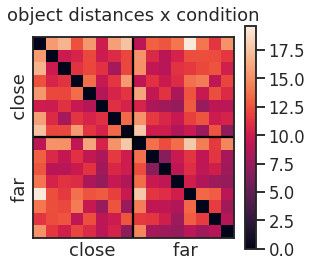

In [16]:
## produce visualization of matrix
from sklearn.metrics import *
sns.set_style('white')
D = pairwise_distances(fmat,metric='euclidean')
plt.matshow(D)
plt.plot((7.5, 7.5), (-0.5, 15.5), 'k-') # vertical refline
plt.plot((-0.5, 15.5), (7.5, 7.5), 'k-') # horizontal refline
plt.colorbar(fraction=0.05)
plt.xticks([])
plt.yticks([])
plt.xlabel('close          far')
plt.ylabel('far          close')
plt.title('object distances x condition')

###### Refresher on properties of variance
https://en.wikipedia.org/wiki/Variance

$ \operatorname{Var}(X) = \frac{1}{n} \sum_{i=1}^n (x_i - \mu)^2 $

$ \operatorname{Var}(X) = \frac{1}{n^2} \sum_{i=1}^n \sum_{j=1}^n \frac{1}{2}(x_i - x_j)^2 = \frac{1}{n^2}\sum_i \sum_{j>i} (x_i-x_j)^2. $

In [17]:
## for each category, compare the within-condition variance 
## and the length of the centroid vector 
to_inspect = 'category'
dist_metric = 'euclidean'
categories = ['bird','car','chair','dog']

for i, this_category in enumerate(categories):
    c,f,obj_list = subset_dataframe_by_condition(F2,
                                        to_inspect=to_inspect,
                                        this_category=this_category,
                                        vgg_feat_num=vgg_feat_num) ## get subset of features

    fmat = np.vstack((np.array(c),np.array(f))) ## stack
    D = pairwise_distances(fmat,metric=dist_metric) ## get distances
    dim = D.shape[0]
    half_dim = int(dim/2)
    triu_inds = np.triu_indices(half_dim,k=1)

    ## get pairwise distances between objects within context condition
    close_pairwise_dists = D[:half_dim,:half_dim][triu_inds]
    far_pairwise_dists = D[half_dim:dim,half_dim:dim][triu_inds]


    ## get euclidean distances of each object from origin 
    frob_c = np.apply_along_axis(np.linalg.norm,1,c)
    frob_f = np.apply_along_axis(np.linalg.norm,1,f)

    ## get std and mean distance from zero for each condition
    far_std = np.mean(far_pairwise_dists)
    far_mean = np.mean(frob_f)

    close_std = np.mean(close_pairwise_dists)
    close_mean = np.mean(frob_c)

    ## compute coefficient of variation, 
    ## measure of what percentage of the mean the dispersion is ...co
    ## if low, indicates higher mean relative to variance
    ## if high, indicates higher variance relative to mean
    ## https://en.wikipedia.org/wiki/Coefficient_of_variation
    far_cv = far_std/far_mean
    close_cv = close_std/close_mean
    print close_std, far_std
    print 'Category: {} | CV for close: {}, CV for far: {}.'.format(this_category, close_cv.round(3), far_cv.round(3))


13.486422 9.212953
Category: bird | CV for close: 1.03499996662, CV for far: 0.751999974251.
10.836642 9.712056
Category: car | CV for close: 0.726999998093, CV for far: 0.737999975681.
21.06999 15.974427
Category: chair | CV for close: 1.02100002766, CV for far: 0.851999998093.
12.134391 10.722824
Category: dog | CV for close: 0.98400002718, CV for far: 0.861000001431.


### characterize context-difference vector

In [18]:
## get difference between close and far
to_inspect = 'category'
categories = ['bird','car','chair','dog']
this_category = categories[0]
d = []
for i, this_category in enumerate(categories):
    c,f, obj_list = subset_dataframe_by_condition(F2,
                                        to_inspect=to_inspect,
                                        this_category=this_category,
                                        vgg_feat_num=vgg_feat_num) ## get subset of features

    _d = c.sub(f)
    if len(d)==0:
        d = _d
    else:
        d = pd.concat((d,_d),axis=0)

<Figure size 576x576 with 0 Axes>

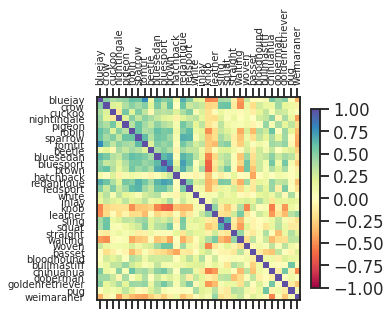

In [19]:
## visualize how well aligned the difference vectors are within a category
ordered_objs = get_ordered_objs_list_by_category(F2)
dist_metric = 'correlation'
D = 1 - pairwise_distances(d,metric=dist_metric)
fig = plt.figure(figsize=(8,8))
plt.matshow(D, cmap=plt.cm.Spectral,vmin=-1.,vmax=1.)
plt.colorbar(fraction=0.04)
plt.xticks([])
plt.yticks([])
t = plt.xticks(range(len(ordered_objs)), ordered_objs, fontsize=10,rotation='vertical')
t = plt.yticks(range(len(ordered_objs)), ordered_objs, fontsize=10)

### measuring relative "spikiness" in close vs. far sketches?
Perhaps using Frobenius norm (root sum squares of each element in the vector),
 which is minimized for uniform vector, and larger for spikier vectors (with larger values concentrated in fewer dimensions)

In [20]:
## helpers
def entropy(probs):    
    return - 1 * sum(map(lambda x: x * np.log(x),probs))

def KL_div_uniform(probs):
    unif_p = 1/len(probs)
    return sum(map(lambda x: unif_p * np.log(unif_p/x),probs))

def softmax(X):
    '''
    input: X is a (1 x N) array
    output: 1 x N array
    '''
    return np.exp(X)/np.sum(np.exp(X))


def minmaxscale(X):

    return (X-np.min(X))/(np.max(X)-np.min(X))

In [21]:
## extract just the feature columns of the feature matrix, and break out by context 
to_inspect = 'all'
c,f, obj_list = subset_dataframe_by_condition(F2,to_inspect=to_inspect,vgg_feat_num=vgg_feat_num)

## convert to numpy array
c = np.array(c)
f = np.array(f)

scale_mode='minmax'  ## minmax or softmax

if scale_mode == 'softmax':
    ## softmax
    soft_c = np.apply_along_axis(softmax,1,c)
    soft_f = np.apply_along_axis(softmax,1,f)
    ## get "spikiness" index on close and far average sketches for each object
    close_norm = np.apply_along_axis(np.linalg.norm,1,soft_c)
    far_norm = np.apply_along_axis(np.linalg.norm,1,soft_f)
    diff_norm = close_norm - far_norm  
elif scale_mode == 'minmax':
    ##minmax

    minmax_c = np.apply_along_axis(minmaxscale,1,c)
    minmax_f = np.apply_along_axis(minmaxscale,1,f)
    ## get "spikiness" index on close and far average sketches for each object
    close_norm = np.apply_along_axis(np.linalg.norm,1,minmax_c)
    far_norm = np.apply_along_axis(np.linalg.norm,1,minmax_f)
    diff_norm = close_norm - far_norm

Mean close spikiness = 3.77620005608  (higher values are spikier)
Mean far spikiness = 3.6875
Mean close-far difference on spikiness = 0.0886999964714


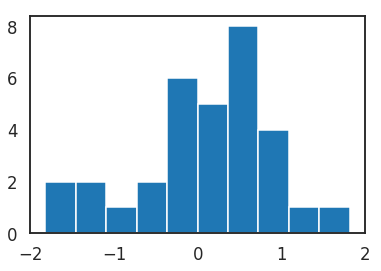

In [22]:
h = plt.hist(diff_norm)
print 'Mean close spikiness = {}  (higher values are spikier)'.format(np.mean(close_norm).round(4))
print 'Mean far spikiness = {}'.format(np.mean(far_norm).round(4))
print 'Mean close-far difference on spikiness = {}'.format(np.mean(diff_norm).round(4))

In [23]:
sp = sum(np.array(diff_norm)>0)
print 'Number of objects for which close was spikier than far: {}'.format(sp)

Number of objects for which close was spikier than far: 19


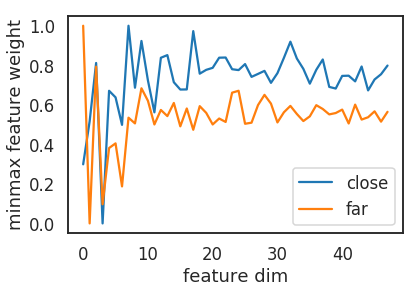

In [24]:
if scale_mode == 'softmax':
    mean_soft_c= np.mean(soft_c,0)
    mean_soft_f = np.mean(soft_f,0)
    l = plt.plot(soft_c[1,:].T,label='close')
    l = plt.plot(soft_f[1,:].T,label='far')
    plt.legend()
    plt.xlabel('feature dim')
    plt.ylabel('softmax feature weight')
elif scale_mode == 'minmax':
    l = plt.plot(minmax_c[0,:].T,label='close')
    l = plt.plot(minmax_f[0,:].T,label='far')
    plt.legend()
    plt.xlabel('feature dim')
    plt.ylabel('minmax feature weight')    

In [25]:
## TODO: Looks like the pattern of peaks might be preserved between close and far, just taller peaks for close, 
## but rank ordering of peaks is preserved? If that is the case, then we predict that the Spearman correlation 
## coefficient will be high between close and far vectors for each object... 
import scipy.stats
run= False
if run==True:
    for i in range(32):
        plt.figure()
        s = plt.scatter(soft_c[i,:],soft_f[i,:])
        plt.title(stats.spearmanr(soft_c[i,:],soft_f[i,:]))


SpearmanrResult(correlation=0.18855840208423794, pvalue=0.199322431402915)


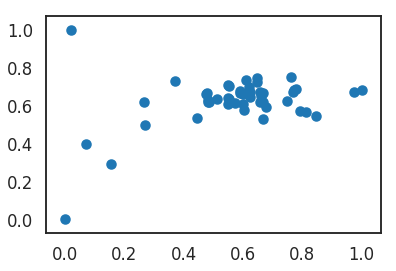

In [26]:
if scale_mode == 'minmax':
    s = plt.scatter(minmax_c[1,:],minmax_f[1,:])
    import scipy.stats
    print stats.spearmanr(minmax_c[1,:],minmax_f[1,:])

### Close-Far part-emphasis analysis

In [27]:
import scipy.stats as stats

def calculate_CI(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return  (m-h).round(3), (m+h).round(3)


In [28]:
close_objs,far_objs, obj_list = subset_dataframe_by_condition(F2, to_inspect= 'all',vgg_feat_num=vgg_feat_num)
print obj_list

## softmax normalize
# close_objs_sm = np.apply_along_axis(softmax,1,close_objs)
# far_objs_sm = np.apply_along_axis(softmax,1,far_objs)
# all_objs_sm= np.vstack((np.array(close_objs_sm),np.array(far_objs_sm)))
# corr_matrix = np.corrcoef(all_objs_sm)

## do not softmax normalize along channels
corr_matrix = np.corrcoef(np.vstack((np.array(close_objs),np.array(far_objs))))

['bluejay' 'crow' 'cuckoo' 'nightingale' 'pigeon' 'robin' 'sparrow'
 'tomtit' 'beetle' 'bluesedan' 'bluesport' 'brown' 'hatchback'
 'redantique' 'redsport' 'white' 'inlay' 'knob' 'leather' 'sling' 'squat'
 'straight' 'waiting' 'woven' 'basset' 'bloodhound' 'bullmastiff'
 'chihuahua' 'doberman' 'goldenretriever' 'pug' 'weimaraner']


<Figure size 648x648 with 0 Axes>

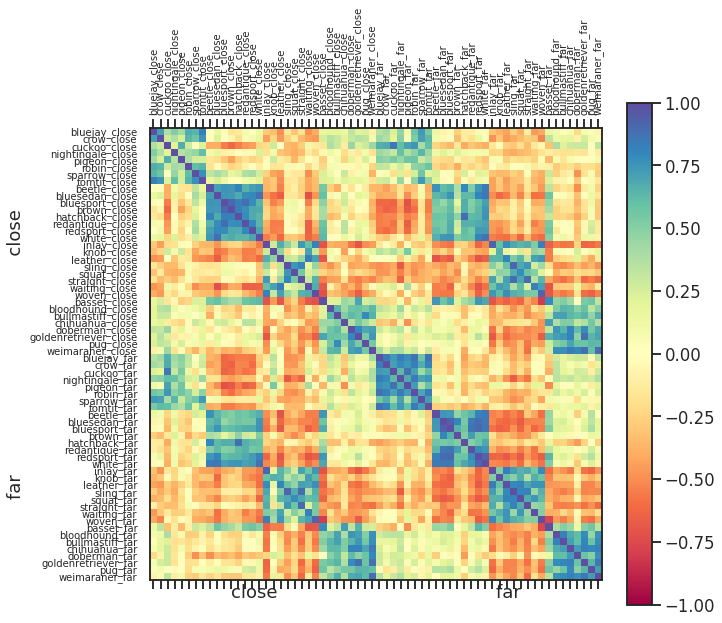

In [29]:
plt.figure(figsize(9,9))
plt.matshow(corr_matrix, cmap=plt.cm.Spectral,vmin=-1.,vmax=1.)
plt.colorbar(fraction=0.05)
plt.xlabel('close                                      far')
plt.ylabel('far                                      close')
plt.xticks([])
plt.yticks([])
close_far_labels = [s +'_close' for s in ordered_objs]+[s +'_far' for s in ordered_objs]
t = plt.xticks(range(len(ordered_objs)*2), close_far_labels, fontsize=10,rotation='vertical')
t = plt.yticks(range(len(ordered_objs)*2), close_far_labels, fontsize=10)

In [32]:
render_plots = False
softmax_feats = False

for i, this_category in enumerate(categories):

    close_objs,far_objs, obj_list = subset_dataframe_by_condition(F2, to_inspect= 'category',this_category=this_category,vgg_feat_num=vgg_feat_num)
    
    if softmax_feats:
        ## optionally apply softmax normalization
        close_objs_sm = np.apply_along_axis(softmax,1,close_objs)
        far_objs_sm = np.apply_along_axis(softmax,1,far_objs)
        all_objs_sm= np.vstack((np.array(close_objs_sm),np.array(far_objs_sm)))
        corr_matrix = np.corrcoef(all_objs_sm)
    else:
        ## take raw correlation 
        corr_matrix = np.corrcoef(np.vstack((np.array(close_objs),np.array(far_objs))))

    dim=corr_matrix.shape[0]
    half_dim = int(corr_matrix.shape[0]/2)     
    cf_corr = corr_matrix[half_dim:dim,:half_dim]    
       
    if render_plots:
        plt.figure(figsize(8,8))
        plt.matshow(corr_matrix, cmap=plt.cm.Spectral,vmin=-1.,vmax=1.)
        plt.colorbar(fraction=0.05)
        plt.title(this_category)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('close                     far')
        plt.ylabel('far                     close')
        close_far_labels =  [s +'_close' for s in ordered_objs]+[s +'_far' for s in ordered_objs]
        plt.figure(figsize(8,8))
        plt.matshow(cf_corr, cmap=plt.cm.Spectral,vmin=-1.,vmax=1.)
        plt.colorbar(fraction=0.04)
        plt.xticks([])
        plt.yticks([])
        plt.title('{} close-far'.format(this_category))
    #t = plt.xticks(range(len(ordered_objs)), [s +'_close' for s in ordered_objs], fontsize=10,rotation='vertical')
    #t = plt.yticks(range(len(ordered_objs)), [s +'_far' for s in ordered_objs], fontsize=10)
    cf_matched_mean = np.mean(np.diag(cf_corr))
    triu_inds = np.triu_indices(half_dim,1)
    cf_off_diag = cf_corr[triu_inds]
    cf_permuted_mean = cf_off_diag.mean()
    print 'Category: {} | Mean of corrs for close-far pairs of the same object is {},CI:{}\
     while the mean of the corr coeffs for permuted pairs is {},CI:{}'.format(this_category, cf_matched_mean.round(3),\
                                                                                    calculate_CI(np.diag(cf_corr)),\
                                                                               cf_permuted_mean.round(3), calculate_CI(cf_off_diag))


Category: bird | Mean of corrs for close-far pairs of the same object is 0.532,CI:(0.403, 0.661)     while the mean of the corr coeffs for permuted pairs is 0.305,CI:(0.213, 0.397)
Category: car | Mean of corrs for close-far pairs of the same object is 0.683,CI:(0.526, 0.84)     while the mean of the corr coeffs for permuted pairs is 0.579,CI:(0.532, 0.625)
Category: chair | Mean of corrs for close-far pairs of the same object is 0.839,CI:(0.762, 0.916)     while the mean of the corr coeffs for permuted pairs is 0.567,CI:(0.501, 0.634)
Category: dog | Mean of corrs for close-far pairs of the same object is 0.694,CI:(0.569, 0.819)     while the mean of the corr coeffs for permuted pairs is 0.606,CI:(0.531, 0.681)


In [ ]:
# Category: bird | Mean of corrs for close-far pairs of the same object is 0.77,CI:(0.692, 0.848)     
# while the mean of the corr coeffs for permuted pairs is 0.692,CI:(0.648, 0.735)
# Category: car | Mean of corrs for close-far pairs of the same object is 0.715,CI:(0.605, 0.824)     
#while the mean of the corr coeffs for permuted pairs is 0.686,CI:(0.64, 0.731)
# Category: chair | Mean of corrs for close-far pairs of the same object is 0.972,CI:(0.957, 0.988)    
#while the mean of the corr coeffs for permuted pairs is 0.796,CI:(0.739, 0.853)
# Category: dog | Mean of corrs for close-far pairs of the same object is 0.745,CI:(0.599, 0.891)     
#while the mean of the corr coeffs for permuted pairs is 0.656,CI:(0.612, 0.699)

In [34]:
## aggregate by target and condition and take the mean across rows within each group
F2 = F0.groupby(['target','condition']).mean().reset_index()

## re-add category back to the F dataframe so we can subset on that later 
##( taking mean above removes it b/c it is a string)
F2['category'] = F2['target'].apply(lambda x: OBJECT_TO_CATEGORY[x])

## sort into standard order
F2 = F2.sort_values(['condition','category','target']).reset_index(drop=True)

## extract just the feature columns and store as np array
PF = np.array(F2[feat_cols])
## do the same for the meta
PM = F2.loc[:,['condition','category','target']]

# optionally apply PCA
apply_pca = True
num_pcs = 2
if apply_pca:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=num_pcs)
    pca.fit(PF)
    print('Applying PCA and transforming data, using {} components'.format(num_pcs))
    PF = pca.fit_transform(PF)

PF = pd.DataFrame(PF)    

## join into single dataframe for plotting
P = pd.concat([PF,PM],axis=1)

Applying PCA and transforming data, using 2 components


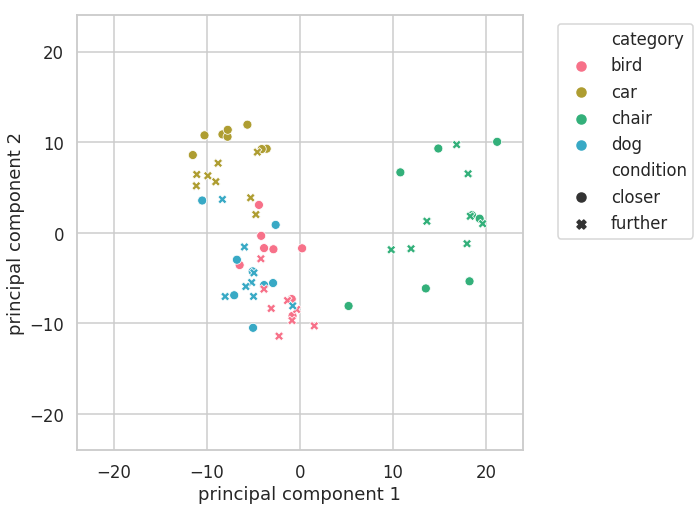

In [37]:
sns.set_style('whitegrid')
colors = sns.color_palette("husl", 5)
sns.scatterplot(data=P,
                x=0,
                y=1,
                hue='category',
                style='condition',
                palette=colors[:4])
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
axlim =  24
plt.xlim(-axlim,axlim)
plt.ylim(-axlim,axlim)
plt.legend(bbox_to_anchor=(1.4,1.))